In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from utils import *

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel("ERROR")

2025-07-16 19:48:43.348693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 19:48:43.363257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752677323.376561   27738 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752677323.380778   27738 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752677323.393251   27738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Sequential API

In [2]:
train_dataset = h5py.File("datasets/train_happy.h5")
train_set_x_orig = np.array(train_dataset["train_set_x"][:])
train_set_y_orig = np.array(train_dataset["train_set_y"][:]).reshape(1, -1)

test_dataset = h5py.File("datasets/test_happy.h5")
test_set_x_orig = np.array(test_dataset["test_set_x"][:])
test_set_y_orig = np.array(test_dataset["test_set_y"][:]).reshape(1, -1)

classes = np.array(test_dataset["list_classes"][:])

xtr = train_set_x_orig/255.
xtt = test_set_x_orig/255.

ytr = train_set_y_orig.T
ytt = test_set_y_orig.T

In [3]:
def sigmoid_model():

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64,64,3)),
        tf.keras.layers.ZeroPadding2D(padding=3),
        tf.keras.layers.Conv2D(32, (7,7), strides=1),
        tf.keras.layers.BatchNormalization(axis=3),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [4]:
happy_model = sigmoid_model()

happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

I0000 00:00:1752677327.054293   27738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
happy_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 64 (256.00 B)

In [6]:
happy_model.fit(xtr, ytr, epochs=10, batch_size=16)

Epoch 1/10


I0000 00:00:1752677328.587576   27820 service.cc:152] XLA service 0x70bfc4009db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752677328.587643   27820 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-16 19:48:48.617514: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752677328.797488   27820 cuda_dnn.cc:529] Loaded cuDNN version 90701


24/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5596 - loss: 1.9171 

I0000 00:00:1752677329.909281   27820 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6176 - loss: 1.6131
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9163 - loss: 0.2481 
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9147 - loss: 0.2230 
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9520 - loss: 0.1144 
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9376 - loss: 0.1606 
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9503 - loss: 0.1317 
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9589 - loss: 0.1149 
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9846 - loss: 0.0424 
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9635 - loss: 0.0890 
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9748 - loss: 0.0772 


In [7]:
happy_model.evaluate(xtt, ytt)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9131 - loss: 0.1522 


[0.14180850982666016, 0.9266666769981384]

## Function API

In [8]:
train_dataset = h5py.File("datasets/train_signs.h5")
train_set_x_orig = np.array(train_dataset["train_set_x"][:])
train_set_y_orig = np.array(train_dataset["train_set_y"][:]).reshape(1, -1)

test_dataset = h5py.File("datasets/test_signs.h5")
test_set_x_orig = np.array(test_dataset["test_set_x"][:])
test_set_y_orig = np.array(test_dataset["test_set_y"][:]).reshape(1, -1)

classes = np.array(test_dataset["list_classes"][:])

xtr1 = train_set_x_orig/255.
xtt1 = test_set_x_orig/255.

ytr1 = convert_to_one_hot(train_set_y_orig, 6).T
ytt1 = convert_to_one_hot(test_set_y_orig, 6).T

In [9]:
def softmax_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    l1 = tf.keras.layers.Conv2D(8, (4,4), strides=1, padding="same")(input_img)
    l2 = tf.keras.layers.ReLU()(l1)
    l3 = tf.keras.layers.MaxPool2D(pool_size=8, strides=8, padding="same")(l2)
    l4 = tf.keras.layers.Conv2D(16, (2,2), strides=1, padding="same")(l3)
    l5 = tf.keras.layers.ReLU()(l4)
    l6 = tf.keras.layers.MaxPool2D(pool_size=4, strides=4, padding="same")(l5)
    F = tf.keras.layers.Flatten()(l6)
    outputs = tf.keras.layers.Dense(6, activation="softmax")(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)

    return model    

In [10]:
conv_model = softmax_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,310 (5.12 KB)

 Trainable params: 1,310 (5.12 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtr1, ytr1)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((xtt1, ytt1)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.1668 - loss: 1.8027 - val_accuracy: 0.1667 - val_loss: 1.7844
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2219 - loss: 1.7836 - val_accuracy: 0.2583 - val_loss: 1.7763
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2740 - loss: 1.7754 - val_accuracy: 0.3000 - val_loss: 1.7682
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3096 - loss: 1.7670 - val_accuracy: 0.3500 - val_loss: 1.7585
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3286 - loss: 1.7575 - val_accuracy: 0.3583 - val_loss: 1.7472
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3461 - loss: 1.7458 - val_accuracy: 0.3667 - val_loss: 1.7340
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3706 - loss: 1.7326 - val_accuracy: 0.3833 - val_loss: 1.7191
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3709 - loss: 1.7148 - val_accuracy: 0.3667 -

In [12]:
conv_model.evaluate(xtt1, ytt1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8744 - loss: 0.4695


[0.4936714172363281, 0.8500000238418579]

In [13]:
history.history

{'accuracy': [0.16388888657093048,
  0.2351851910352707,
  0.27222222089767456,
  0.31018519401550293,
  0.32685184478759766,
  0.34074074029922485,
  0.3638888895511627,
  0.37037035822868347,
  0.3870370388031006,
  0.3879629671573639,
  0.4055555462837219,
  0.4148148000240326,
  0.43611112236976624,
  0.44999998807907104,
  0.46574074029922485,
  0.4740740656852722,
  0.47962963581085205,
  0.5,
  0.5111111402511597,
  0.5259259343147278,
  0.5333333611488342,
  0.5527777671813965,
  0.5685185194015503,
  0.5814814567565918,
  0.5972222089767456,
  0.6157407164573669,
  0.6379629373550415,
  0.6481481194496155,
  0.6592592597007751,
  0.6611111164093018,
  0.6824073791503906,
  0.6925926208496094,
  0.7046296000480652,
  0.7074074149131775,
  0.7166666388511658,
  0.7240740656852722,
  0.7287036776542664,
  0.7277777791023254,
  0.729629635810852,
  0.7342592477798462,
  0.7388888597488403,
  0.7472222447395325,
  0.7527777552604675,
  0.7555555701255798,
  0.760185182094574,
  0.7

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

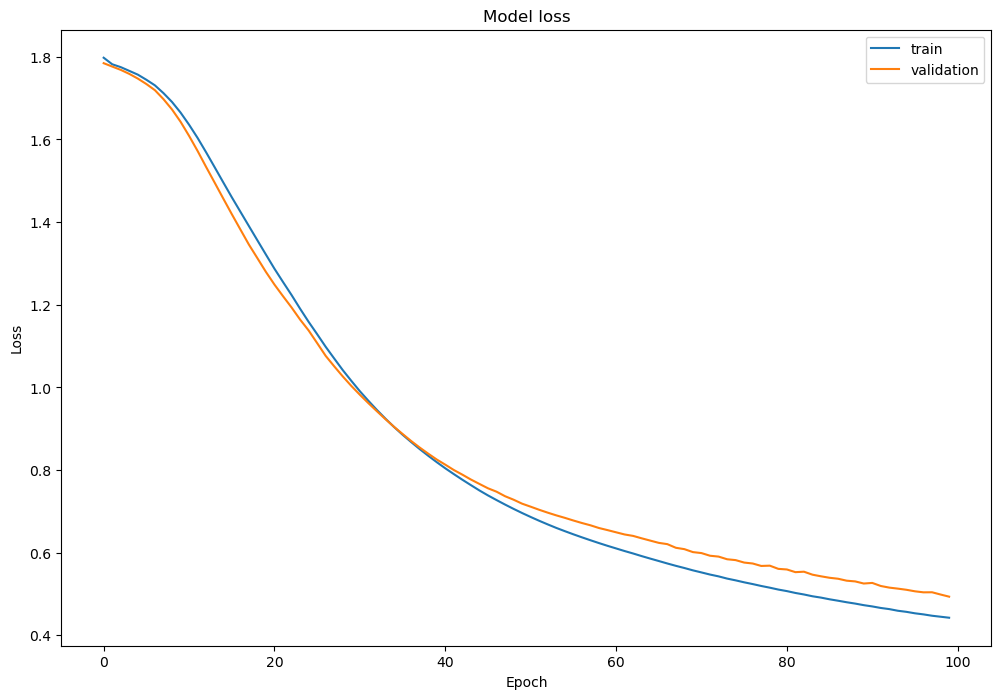

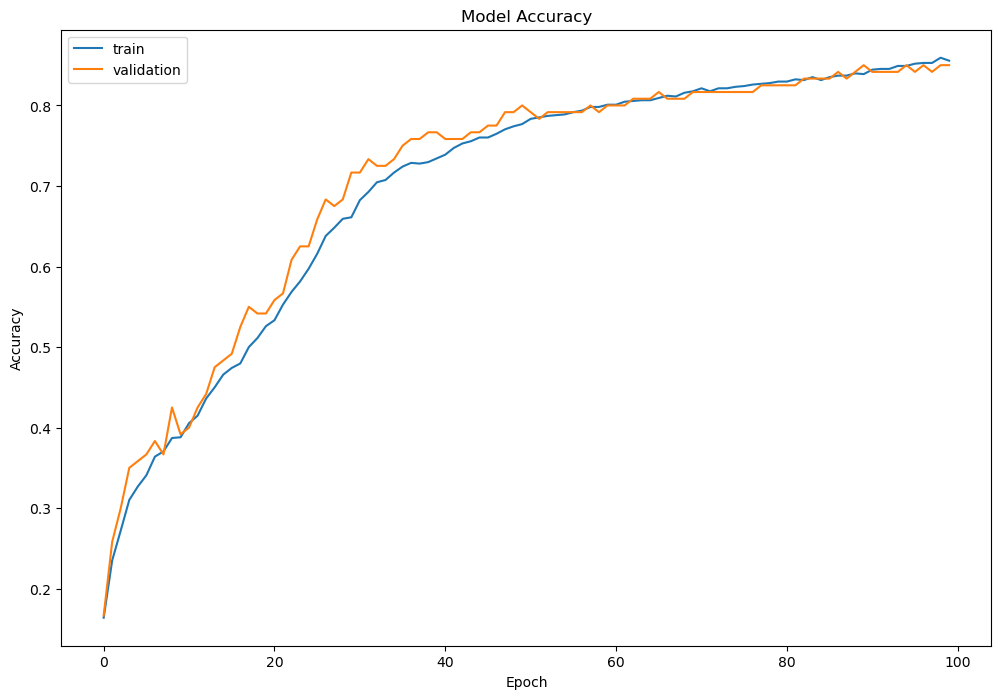

In [14]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss = df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc = df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'})
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')